Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
from ClassImplementation import GaussianMixtureModel

Data Loading and Preprocessing

In [2]:
DATA_PATH = 'data.csv'
np.random.seed(42)

try:
    df = pd.read_csv(DATA_PATH)
    print(f"Loaded raw data: {df.shape}")
except FileNotFoundError:
    raise FileNotFoundError(f"File '{DATA_PATH}' not found.")

df = df.dropna(axis=1, how='all')

df = df.dropna(axis=0)

if 'id' in df.columns:
    df = df.drop(columns=['id'])

target_col = None
possible_targets = ['diagnosis', 'target', 'label', 'class']
for col in possible_targets:
    if col in df.columns:
        target_col = col
        break

if target_col:
    y_raw = df[target_col].values
    if y_raw.dtype == object:
        unique_classes = np.unique(y_raw)
        class_map = {label: idx for idx, label in enumerate(unique_classes)}
        y = np.array([class_map[val] for val in y_raw])
    else:
        y = y_raw
    X_raw_df = df.drop(columns=[target_col])
else:
    y = None
    X_raw_df = df

X_raw_df = X_raw_df.apply(pd.to_numeric, errors='coerce')
X_raw_df = X_raw_df.dropna() 
X_raw = X_raw_df.values
X_mean = np.nanmean(X_raw, axis=0)
X_std = np.nanstd(X_raw, axis=0)

X_std[X_std == 0] = 1.0 

X_scaled = (X_raw - X_mean) / X_std

if np.isnan(X_scaled).any() or np.isinf(X_scaled).any():
    raise ValueError("Preprocessing failed: X_scaled still contains NaNs or Infs. Check your dataset for non-numeric strings.")

print(f"Cleaned Data Shape: {X_scaled.shape}")

Loaded raw data: (569, 33)
Cleaned Data Shape: (569, 30)


GMM on origonal Data

In [3]:
n_components_range = range(1, 8) 
covariance_types = ['full', 'tied', 'diag', 'spherical']
results_data = []
trained_models = {}

print("Starting Experiment 2...")

for cov_type in covariance_types:
    print(f"  Testing Covariance: {cov_type}")
    for n_comp in n_components_range:
        gmm = GaussianMixtureModel(n_components=n_comp, covariance_type=cov_type, max_iter=100)
        gmm.fit(X_scaled)
        
        bic_score = gmm.bic(X_scaled)
        aic_score = gmm.aic(X_scaled)
        final_ll = gmm.log_likelihood_history_[-1]
        
        results_data.append({
            'covariance_type': cov_type,
            'n_components': n_comp,
            'BIC': bic_score,
            'AIC': aic_score,
            'Log_Likelihood': final_ll
        })
        
        trained_models[(cov_type, n_comp)] = gmm

results_df = pd.DataFrame(results_data)
print("Experiment 2 Completed.")

Starting Experiment 2...
  Testing Covariance: full
  Testing Covariance: tied
  Testing Covariance: diag
  Testing Covariance: spherical
Experiment 2 Completed.


Visualization

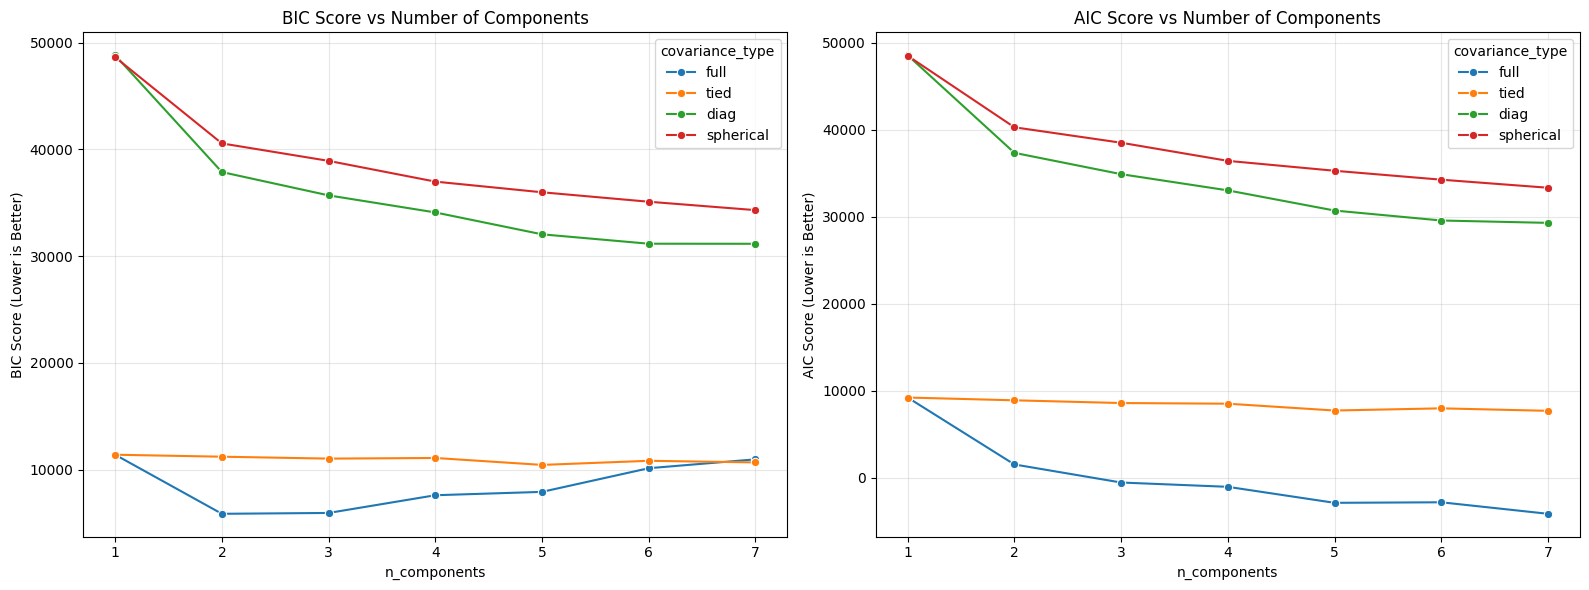

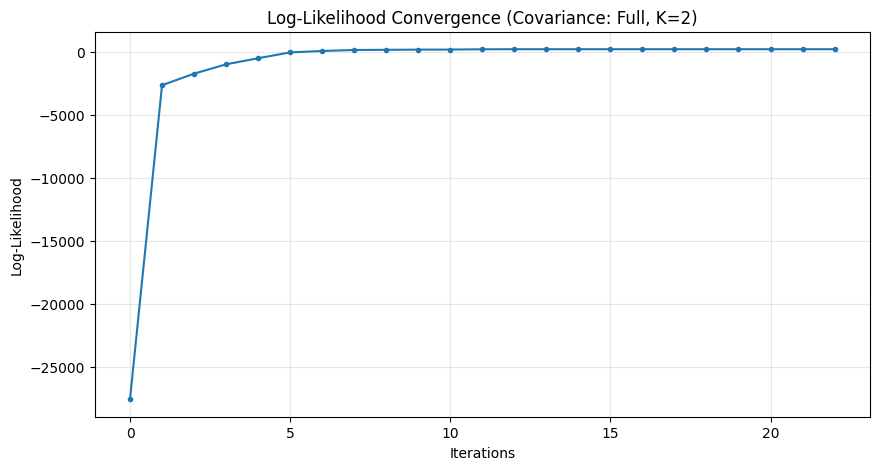

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(data=results_df, x='n_components', y='BIC', hue='covariance_type', marker='o', ax=axes[0])
axes[0].set_title('BIC Score vs Number of Components')
axes[0].set_ylabel('BIC Score (Lower is Better)')
axes[0].grid(True, alpha=0.3)

sns.lineplot(data=results_df, x='n_components', y='AIC', hue='covariance_type', marker='o', ax=axes[1])
axes[1].set_title('AIC Score vs Number of Components')
axes[1].set_ylabel('AIC Score (Lower is Better)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

rep_key = ('full', 2)
if rep_key in trained_models:
    rep_model = trained_models[rep_key]
    
    plt.figure(figsize=(10, 5))
    plt.plot(rep_model.log_likelihood_history_, marker='.')
    plt.title(f'Log-Likelihood Convergence (Covariance: Full, K=2)')
    plt.xlabel('Iterations')
    plt.ylabel('Log-Likelihood')
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print(f"Model {rep_key} not found in results.")